In [1]:
import pandas

pandas.set_option('display.max_rows', None, 'display.max_columns', None)
spending_data = pandas.read_csv('../data/csv/cabinet_member_spending.csv')

In [207]:
REPUBLICAN_PRESIDENTS = ('George W. Bush', 'Donald Trump')
DEMOCRATIC_PRESIDENTS = ('Barack Obama', )
REPUBLICAN_PARTY = 0
DEMOCRATIC_PARTY = 1

normalized_spending_data = pandas.DataFrame(columns=['department', 'party', 'domestic_spending_ratio'])
normalized_spending_data = normalized_spending_data.assign(
    department=spending_data['Department'],
    party=spending_data['President'].map(lambda president: REPUBLICAN_PARTY if president in REPUBLICAN_PRESIDENTS else DEMOCRATIC_PARTY),
    domestic_spending_ratio=spending_data['domestic_spending']/(spending_data['domestic_spending'] + spending_data['foreign_spending']),
)

In [238]:
medians = normalized_spending_data.groupby(['department', 'party'], as_index=False)['domestic_spending_ratio'].median()

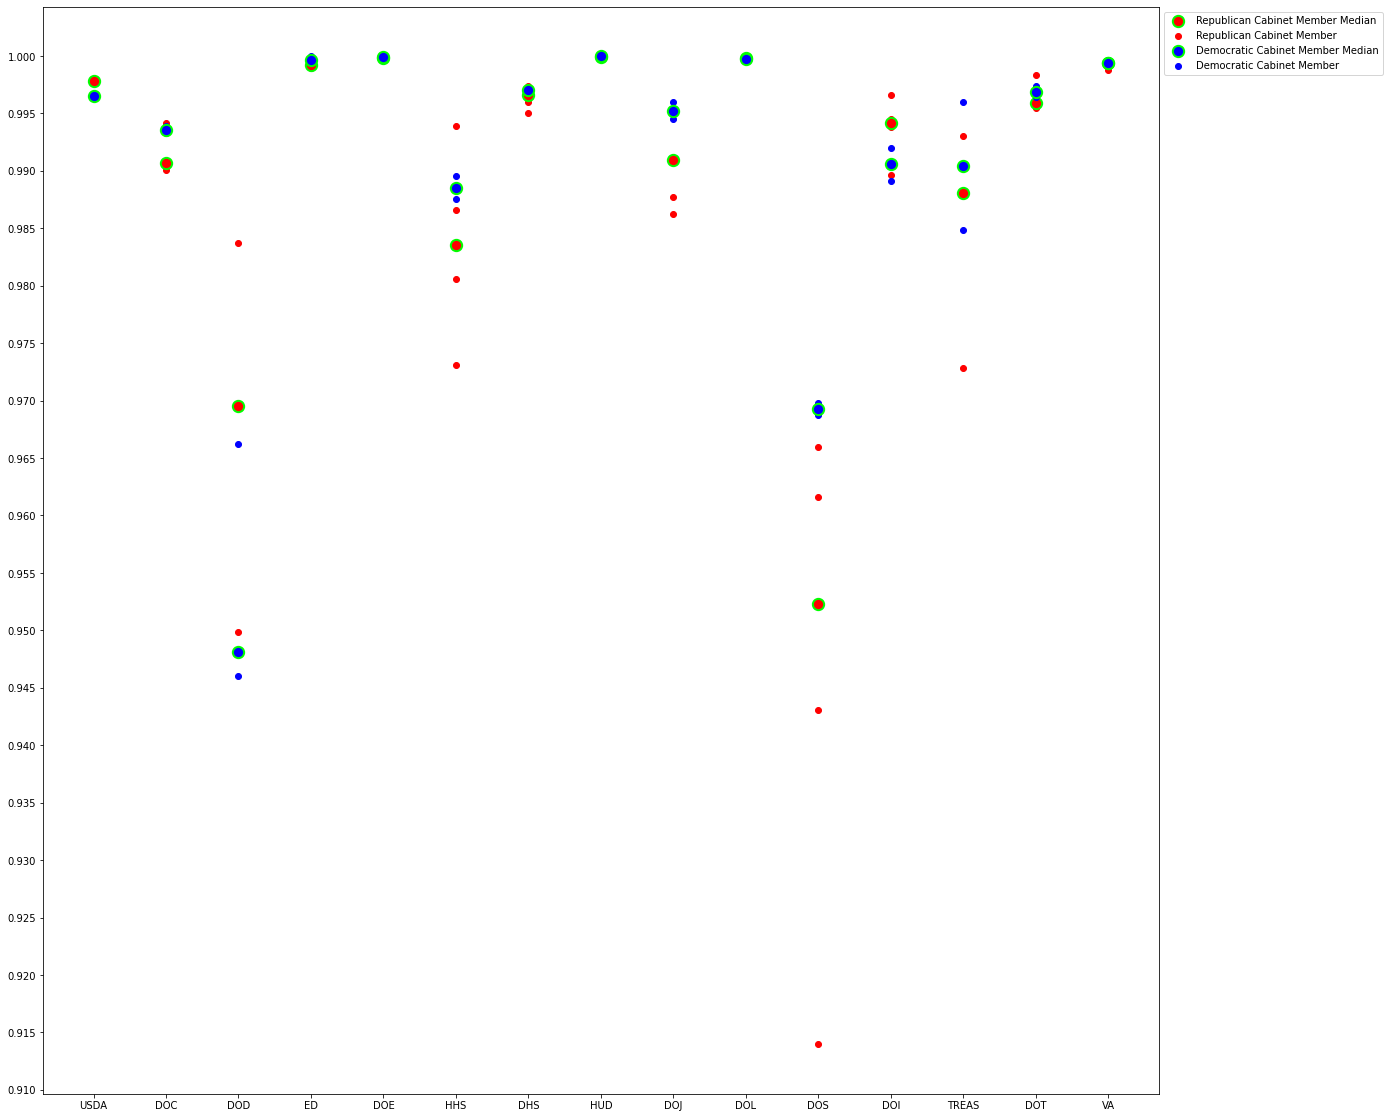

In [242]:
import matplotlib.ticker
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 20]
plot_entities = [
    {
        'party': REPUBLICAN_PARTY,
        'color': 'red',
        'label': 'Republican Cabinet Member'
    },
    {
        'party': DEMOCRATIC_PARTY,
        'color': 'blue',
        'label': 'Democratic Cabinet Member'
    },
]

plot_handles = []
for entity in plot_entities:
    party_data = normalized_spending_data[normalized_spending_data['party'] == entity['party']]
    department_handle = plt.scatter(
        [department.split("(")[1].split(")")[0] for department in party_data['department']], 
        party_data['domestic_spending_ratio'],
        c=entity['color'],
        label=entity['label']
    )

    party_medians = medians[medians['party'] == entity['party']]
    median_handle = plt.scatter(
        [department.split("(")[1].split(")")[0] for department in party_medians['department']], 
        party_medians['domestic_spending_ratio'],
        edgecolors='lime',
        facecolors=entity['color'],
        s=128,
        linewidths=2,
        label=entity['label'] + ' Median'
    )

    plot_handles += [median_handle, department_handle]

plt.legend(handles=plot_handles, bbox_to_anchor=(1, 1));
axes = plt.axes()
axes.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.005))

## We will now calculate the difference between Republican domestic spending and Democratic domestic spending.
### A negative number indicates that Democrats spent more domestically in their department, while a positive represents the opposite.

In [332]:
all_department_medians = {}
for department in medians['department'].unique():
    all_department_medians[department] = medians[medians['department'] == department]

department_differences = pandas.DataFrame(columns=['department', 'difference'])
for department, department_medians in all_department_medians.items():
    difference = (
        float(department_medians[department_medians['party'] == REPUBLICAN_PARTY]['domestic_spending_ratio'])
        - float(department_medians[department_medians['party'] == DEMOCRATIC_PARTY]['domestic_spending_ratio'])
    )

    department_differences = department_differences.append(
        pandas.DataFrame({
                'department': [department],
                'difference': [difference],
            }),
    )

department_differences.reset_index(drop=True, inplace=True)

In [353]:
median = department_differences["difference"].abs().median()
mean = department_differences["difference"].abs().mean()
std = department_differences["difference"].abs().std()

print(f'Median magnitude of difference: {median * 100:0.3}%', )
print(f'Average magnitude of difference: {mean * 100:0.3}%', )
print(f'Std. Dev of magnitude of difference: {std * 100:0.3}%')
print('')

# Scale the dataframe to be percentages out of 100, rather than just decimals
scaled_differences = department_differences.copy()
scaled_differences['difference'] = scaled_differences['difference'] * 100

# Sort these scaled differences by the magnitude of their difference
scaled_differences = scaled_differences.loc[scaled_differences['difference'].abs().sort_values(ascending=False).index]

print('Differences in spending, sorted by the magnitude of difference')
scaled_differences.style.format({'difference': '{:0.3}%'})

Median magnitude of difference: 0.126%
Average magnitude of difference: 0.399%
Std. Dev of magnitude of difference: 0.643%

Differences in spending, sorted by the magnitude of difference


,department,difference
2,DEPARTMENT OF DEFENSE (DOD),2.14%
10,DEPARTMENT OF STATE (DOS),-1.69%
5,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),-0.498%
8,DEPARTMENT OF JUSTICE (DOJ),-0.429%
11,DEPARTMENT OF THE INTERIOR (DOI),0.361%
1,DEPARTMENT OF COMMERCE (DOC),-0.291%
12,DEPARTMENT OF THE TREASURY (TREAS),-0.234%
0,DEPARTMENT OF AGRICULTURE (USDA),0.126%
13,DEPARTMENT OF TRANSPORTATION (DOT),-0.102%
3,DEPARTMENT OF EDUCATION (ED),-0.0448%
